<a href="https://colab.research.google.com/github/YasinnSoylu/fastai-covid_19-classification/blob/main/fastai_covid_19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# If the following warning message annoys you....
#UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries
#Install older version of torch 
!pip install "torch==1.4" "torchvision==0.5.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import torch
print(torch.__version__)

1.4.0


In [27]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [28]:
#You may already have this preinstalled and available on Colab
!pip install fastai==1.0.61


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
from fastai.vision import get_transforms, ImageDataBunch, cnn_learner, ClassificationInterpretation, models 
from fastai.metrics import error_rate, accuracy

In [31]:
image_directory = '/content/drive/MyDrive/covid_dataset/Covid19-dataset'

In [32]:
#https://fastai1.fast.ai/vision.transform.html#get_transforms
tfms = get_transforms(do_flip=True, max_rotate=10.0, )

In [33]:
# The transformers are already built into the model
# num_workers = how many subprocesses to use for data loading
data = ImageDataBunch.from_folder(image_directory, train='train', valid='test', ds_tfms=tfms, size=224, bs=64, num_workers=8)

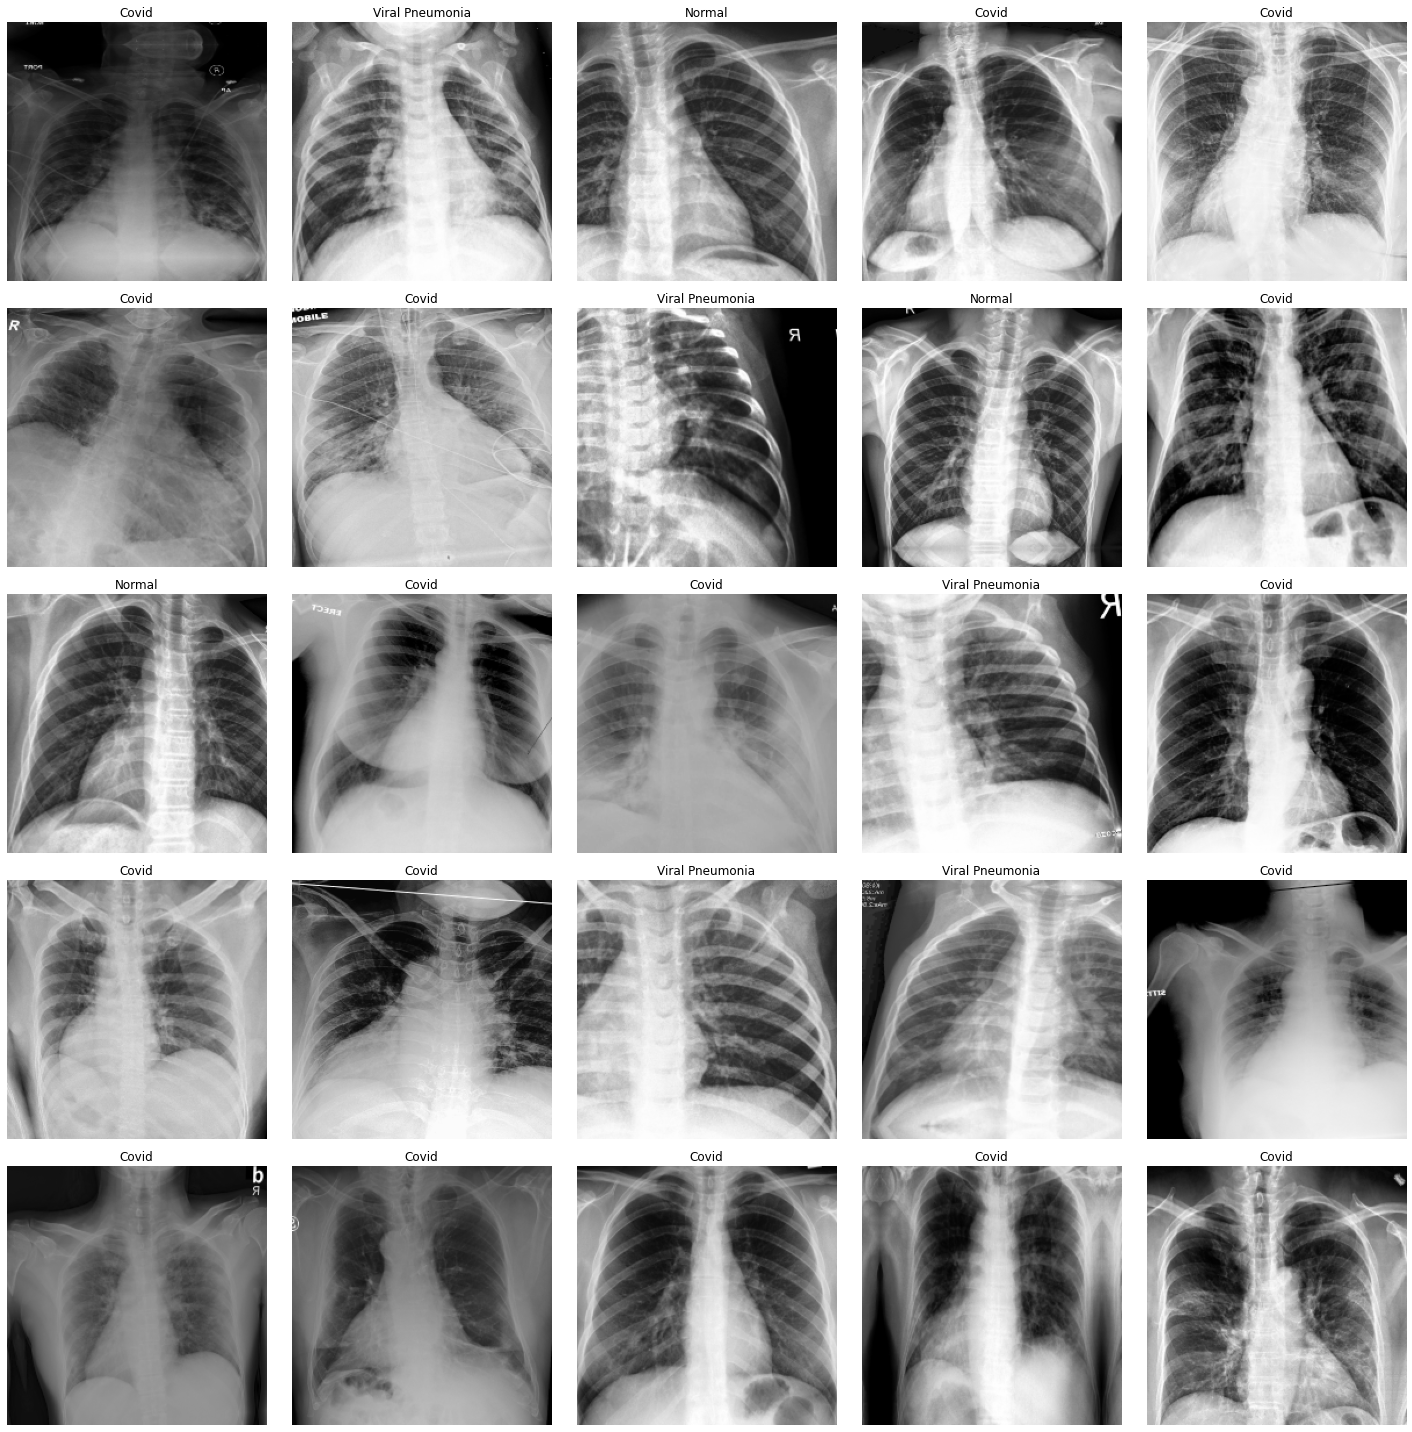

In [34]:
# Show what the data looks like after being transformed
data.show_batch()


In [35]:
# See the classes and count of classes in your dataset
print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

['Covid', 'Normal', 'Viral Pneumonia'] 3
251 66


In [36]:
#To find out all available vision models 
dir(models)
#We will use resnet34. By default it downloads Imagenet pretrained weights. 

['BasicBlock',
 'Darknet',
 'DynamicUnet',
 'ResLayer',
 'ResNet',
 'SqueezeNet',
 'UnetBlock',
 'WideResNet',
 'XResNet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'darknet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet1_0',
 'squeezenet1_1',
 'unet',
 'vgg11_bn',
 'vgg13_bn',
 'vgg16_bn',
 'vgg19_bn',
 'wrn',
 'wrn_22',
 'xception',
 'xresnet',
 'xresnet101',
 'xresnet152',
 'xresnet18',
 'xresnet18_deep',
 'xresnet34',
 'xresnet34_deep',
 'xresnet50',
 'xresnet50_deep']

In [37]:
# Build the CNN model with the pretrained resnet18
learn = cnn_learner(data, models.resnet18, metrics = [accuracy, error_rate])

In [38]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

By default all layers are frozen except for the last layer, classifier layer. When we train the model using fit_one_cycle it only trains the last layer. If we want all layers to be trainable, we need to unfreeze the model using learn.unfreeze()

In [39]:
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 2.29E-03


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


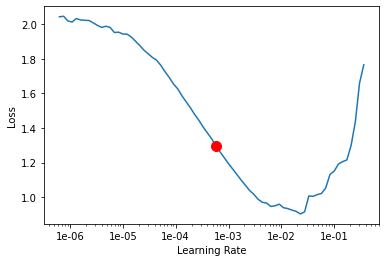

In [40]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

 **Fit the model**

Make sure to use discriminative learning rates here(parameter max_lr), which maintains a low learning rate for initial layers as they need lesser tuning and gradually increase learning rate for later layers which need higher tuning especially fully connected ones.

In [41]:
# Fit the model over 2 epochs
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.022772,1.092817,0.515152,0.484848,00:20
1,2.010697,1.011630,0.530303,0.469697,00:19
2,1.903992,0.974991,0.560606,0.439394,00:20
3,1.782110,0.937633,0.621212,0.378788,00:22
4,1.616948,0.977508,0.621212,0.378788,00:20
5,1.497658,1.072348,0.621212,0.378788,00:20
6,1.368527,1.155661,0.666667,0.333333,00:20
7,1.270286,1.245622,0.651515,0.348485,00:20
8,1.172992,1.302238,0.636364,0.363636,00:20
9,1.109334,1.277701,0.696970,0.303030,00:22


In [42]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn)

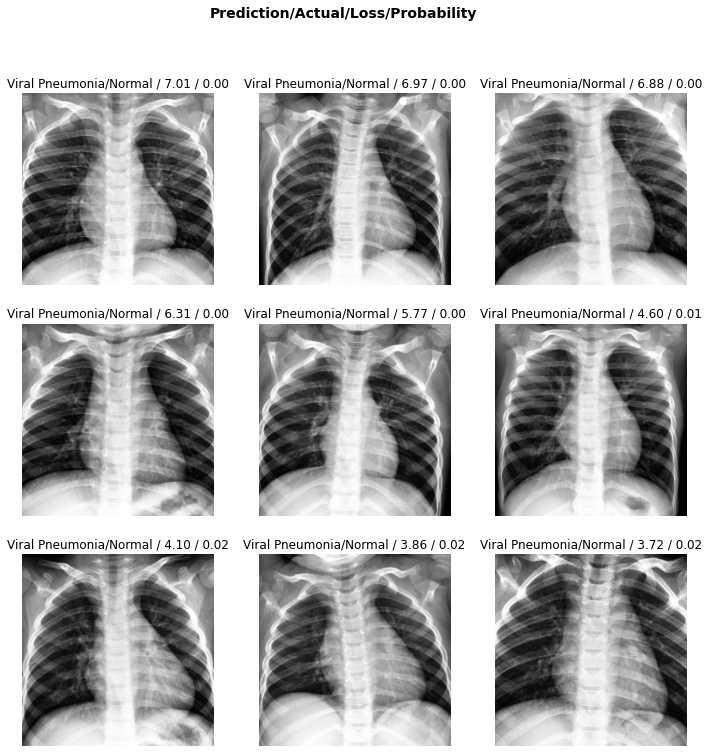

In [43]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(9, figsize=(12,12), heatmap=False)

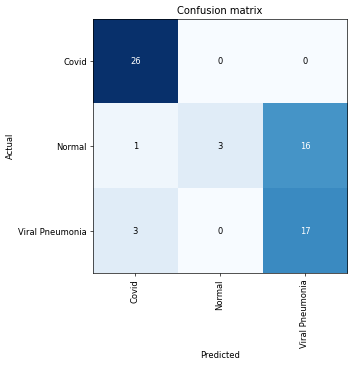

In [44]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [45]:
#To view the list of classes most misclassified as a list
interp.most_confused(min_val=2) #We are ignoring single image misclassification

#Sorted descending list of largest non-diagonal entries of confusion matrix, 
#presented as actual, predicted, number of occurrences.

[('Normal', 'Viral Pneumonia', 16), ('Viral Pneumonia', 'Covid', 3)]

# strategy2

In [46]:
learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True
                      ,metrics=[error_rate, accuracy]).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.76E-04
Min loss divided by 10: 3.80E-03


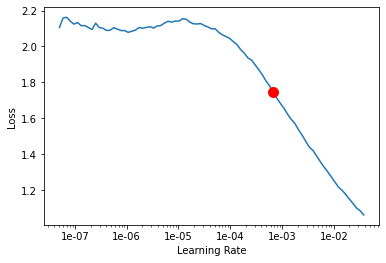

In [47]:
learner.lr_find(start_lr=1e-08,end_lr=0.1, num_it=100) 
learner.recorder.plot(suggestion=True)

In [48]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.0006760829753919812


# Training the leraner 


In [49]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.895331,2.246046,0.621212,0.378788,00:20
1,1.796520,1.523816,0.484848,0.515152,00:20
2,1.634857,1.160695,0.424242,0.575758,00:21
3,1.372456,1.091231,0.333333,0.666667,00:20
4,1.200723,1.093114,0.318182,0.681818,00:22
5,1.079666,1.023741,0.303030,0.696970,00:20
6,0.974871,0.868370,0.287879,0.712121,00:20
7,0.884472,0.757484,0.272727,0.727273,00:19
8,0.810056,0.703989,0.242424,0.757576,00:20
9,0.754330,0.692326,0.257576,0.742424,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.59E-07
Min loss divided by 10: 1.67E-04


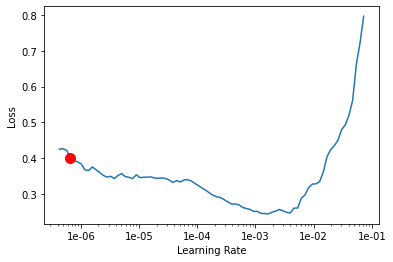

In [50]:
learner.unfreeze()
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [51]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

6.593771596754481e-07


# Differential learning

In [52]:
# Differential learning 
learner.fit_one_cycle(7, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.261667,0.670732,0.242424,0.757576,00:21
1,0.281365,0.676160,0.227273,0.772727,00:20
2,0.321259,0.638319,0.227273,0.772727,00:20
3,0.336243,0.630242,0.242424,0.757576,00:21
4,0.356858,0.605270,0.212121,0.787879,00:20
5,0.385938,0.578816,0.212121,0.787879,00:23
6,0.395090,0.538100,0.242424,0.757576,00:20


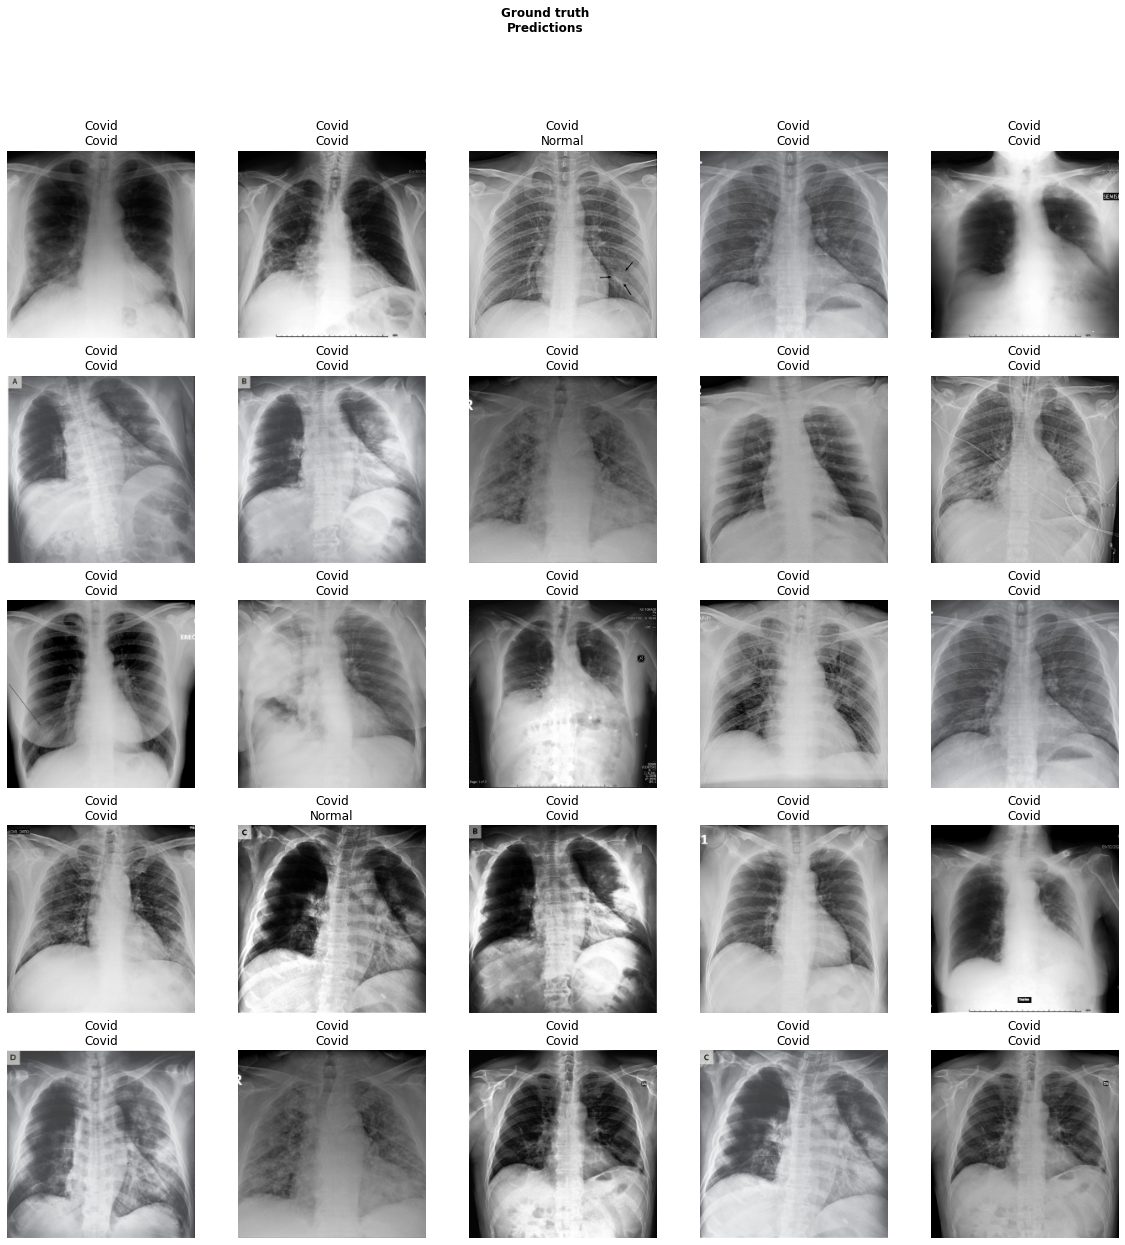

In [58]:
learner.show_results()

In [54]:
interp = ClassificationInterpretation.from_learner(learner)


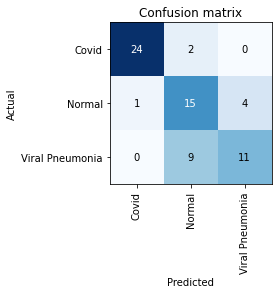

In [55]:
interp.plot_confusion_matrix(title='Confusion matrix')